In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import gc
import gzip
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
import pickle

# Load raw TCCs into memory

In [3]:
tsvfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.tsv'
COOinput = pd.read_csv( tsvfile_dir, delimiter='\t',header=None, dtype=int)

A=COOinput.as_matrix()

rows,cols,data = A.T

In [4]:
nonzero_ec = np.unique(rows)
map_rows = { val:ind for ind,val in enumerate( nonzero_ec ) }
map_cols = { val:ind for ind,val in enumerate( np.unique(cols) ) }
TCCmatrix   = coo_matrix( (data.astype(float),( [map_rows[r] for r in rows], [map_cols[c] for c in cols]) ) ) 

NUM_OF_CELLS = TCCmatrix.shape[1]
print("NUM_OF_CELLS =", NUM_OF_CELLS)
      
T = TCCmatrix.tocsr()

NUM_OF_CELLS = 31834


In [5]:
del TCCmatrix,map_cols,map_rows,A,rows,cols,data;
_ = gc.collect()

In [6]:
ecfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.ec'
eclist=pd.read_csv( ecfile_dir, delimiter='\t',header=None, dtype=str)
eclist=np.array(eclist)

In [7]:
cellfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.cells'
celllist=pd.read_csv( cellfile_dir, delimiter='\t',header=None, dtype=str)
print(celllist.iloc[123][0][10:-1])

ACCCAAGATTGGTG-M


In [8]:
cellnames=[]
for i in range(len(celllist.index)):
    cellnames+=[celllist.iloc[i][0][10:-1]]
cellnames=np.array(cellnames)

In [9]:
#Save data
with open("./TCC_matrix_MNC.dat", 'wb') as f:
    pickle.dump(T,f)
with open("./nonzero_ec_MNC.dat", 'wb') as f:
    pickle.dump(nonzero_ec,f)
with open("./eclist_MNC.dat", 'wb') as f:
    pickle.dump(eclist,f)
with open("./cellnames_MNC.dat", 'wb') as f:
    pickle.dump(cellnames,f)
    


##  Load pickled TCCs

In [9]:
#Load dataset   
with open("./TCC_matrix_MNC.dat", 'rb') as f:
    T=pickle.load(f)
with open("./nonzero_ec_MNC.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
with open("./eclist_MNC.dat", 'rb') as f:
    eclist=pickle.load(f)
with open("./cellnames_MNC.dat", 'rb') as f:
    cellnames=pickle.load(f)

### quality control

In [10]:
# median umis per cell
print("median UMIs per cell:",np.median(np.array((np.sum(T,axis=0))).reshape(1,-1)[0]))

median UMIs per cell: 5248.0


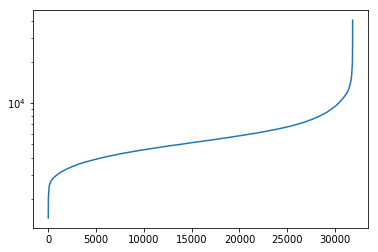

In [11]:
readspercell=np.array((np.sum(T,axis=0))).reshape(1,-1)[0]
plt.semilogy(np.sort(readspercell))

In [12]:
hi_low=[30000,1000]
cells_keep = np.where(readspercell<hi_low[0])[0]
idx = np.where(readspercell[cells_keep]>hi_low[1])[0]
cells_keep=cells_keep[idx]

In [13]:
cellnames = cellnames[cells_keep]

In [14]:
cells_keep.shape

(31831,)

In [15]:
T=T[:,cells_keep]

#### ECdict

In [16]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=np.sort(list(union)) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC) #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 133229


In [23]:
path_to_ref='../Homo_sapiens.GRCh38.rel79.cdna.all.utr_mod.fa.gz'

ENSG_PRPTC = 'ENSG00000262418'

def readENS_ids(path_to_ref):
    TX_to_ENST={}
    TX_to_ENSG={}
    ENSG_isoforms={}
    line_cnt=0;
    tx_cnt=0;
    with gzip.open(path_to_ref) as f:
        for line in f:
            if line.decode('UTF-8')[0]=='>':
                liner=line.decode('UTF-8')
                if line_cnt == union_list[tx_cnt]:
                    if liner.split("ENST",1)[1][11:].startswith('_utr_mod'):
                        TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:20]
                        TX_to_ENSG[union_list[tx_cnt]] = ENSG_PRPTC
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                        tx_cnt+=1 
                    else:
                        TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:11]
                        TX_to_ENSG[union_list[tx_cnt]] = 'ENSG'+liner.split("ENSG",1)[1][:11]
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                        tx_cnt+=1 
                    if tx_cnt==NUM_OF_TX_inTCC: return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]
                line_cnt+=1
    return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]


[TX_to_ENST,TX_to_ENSG,ENSG_isoforms]=readENS_ids(path_to_ref)       

In [24]:
EC_ENST_DICT={}
EC_ENSG_DICT={}
for ec in nonzero_ec:
    EC_ENST_DICT[ec] = [TX_to_ENST[tx] for tx in EC_dict[ec]]    
    EC_ENSG_DICT[ec] = list(np.unique([TX_to_ENSG[tx] for tx in EC_dict[ec]])) 

In [25]:
ENST_to_TX = {v: k for k, v in TX_to_ENST.items()}

In [26]:
#inv_map ; NOTE: genes and transcripts may be associated with multiple ensg accession numbers
ENSG_EC_DICT={}
for k, v in EC_ENSG_DICT.items():
    for vi in v:
        ENSG_EC_DICT[vi] = ENSG_EC_DICT.get(vi, [])
        ENSG_EC_DICT[vi].append(k)
        
ENST_EC_DICT={}
for k, v in EC_ENST_DICT.items():
    for vi in v:
        ENST_EC_DICT[vi] = ENST_EC_DICT.get(vi, [])
        ENST_EC_DICT[vi].append(k)

In [27]:
all_genes_ids = np.unique(list(TX_to_ENSG.values()))
print("NUM_OF_GENE_IDs =", len(all_genes_ids))

NUM_OF_GENE_IDs = 25940


In [28]:
clean_gene_ids=[]

for gene in all_genes_ids:
    if len(list(np.unique([EC_ENSG_DICT[ec] for ec in ENSG_EC_DICT[gene]]))) == 1:
        clean_gene_ids+=[gene]
clean_gene_ids=np.array(clean_gene_ids)

In [29]:
print("NUM_OF_CLEAN_GENE_IDs =", len(clean_gene_ids))

NUM_OF_CLEAN_GENE_IDs = 6234


#### gene names

In [30]:
#gene ids to gene names (requires "pip install mygene")
import mygene
mg = mygene.MyGeneInfo()
ginfo = mg.querymany(all_genes_ids, scopes='ensembl.gene',returnall=True)

with open('ginfo_MNC.pickle', 'wb') as handle:
    pickle.dump(ginfo, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #LOAD
# with open('ginfo_MNC.pickle', 'rb') as handle:
#     ginfo = pickle.load(handle)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-25940...done.
Finished.
183 input query terms found dup hits:
	[('ENSG00000011454', 2), ('ENSG00000023171', 2), ('ENSG00000058600', 2), ('ENSG00000072195', 2), ('E
194 input query terms found no hit:
	['ENSG00000069712', 'ENSG00000116957', 'ENSG00000130201', 'ENSG00000133808', 'ENS

In [31]:
missing_names=ginfo['missing']
duplicate_names=ginfo['dup']

In [32]:
#ENSG to Gene-Names
all_gene_id_to_names={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        ensg_id=str(g['query'])
        all_gene_id_to_names[ensg_id] = all_gene_id_to_names.get(ensg_id, [])
        all_gene_id_to_names[ ensg_id].append(str(g['symbol']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_id_to_names[ str(g['query']) ] = [str(g['query'])]
        
#Gene-Names to ENSG
all_gene_names_to_id={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        gene_name=str(g['symbol'])
        all_gene_names_to_id[gene_name] = all_gene_names_to_id.get(gene_name, [])
        all_gene_names_to_id[ gene_name].append(str(g['query']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_names_to_id[ str(g['query']) ] = [str(g['query'])]

In [33]:
def search_gene(starting_letters):
    print("SEARCHING: ",starting_letters,"...")
    for gene in all_genes_ids:
        if all_gene_id_to_names[gene][0][:len(starting_letters)] == starting_letters:
            print(gene,all_gene_id_to_names[gene])
    print("DONE")

In [34]:
EC_IDX={}
for i in range(len(nonzero_ec)):
    EC_IDX[nonzero_ec[i]] =i 

# PTPRC

In [35]:
gene="PTPRC"
all_gene_names_to_id[gene]

['ENSG00000081237', 'ENSG00000262418']

In [37]:
ENSG_isoforms['ENSG00000262418']

['ENST00000573298',
 'ENST00000575923',
 'ENST00000573679',
 'ENST00000574399',
 'ENST00000576833',
 'ENST00000573477',
 'ENST00000570609',
 'ENST00000571847',
 'ENST00000574441',
 'ENST00000573971',
 'ENST00000572593',
 'ENST00000574718',
 'ENST00000570905',
 'ENST00000575803',
 'ENST00000442510_utr_mod1',
 'ENST00000348564_utr_mod1',
 'ENST00000575923_utr_mod2',
 'ENST00000573679_utr_mod2',
 'ENST00000576833_utr_mod2',
 'ENST00000573477_utr_mod2',
 'ENST00000574441_utr_mod2',
 'ENST00000530727_utr_mod2',
 'ENST00000442510_utr_mod2',
 'ENST00000367367_utr_mod2',
 'ENST00000348564_utr_mod2',
 'ENST00000529828_utr_mod2',
 'ENST00000442510_utr_mod3',
 'ENST00000367367_utr_mod3',
 'ENST00000348564_utr_mod3',
 'ENST00000529828_utr_mod3',
 'ENST00000442510_utr_mod4',
 'ENST00000348564_utr_mod4']

In [38]:
gene_ecs0=[]
for g in all_gene_names_to_id[gene]:
    gene_ecs0+=ENSG_EC_DICT[g]
gene_ecs0=np.unique(gene_ecs0)

In [39]:
gene_ecs0

array([185843, 199837, 211377, 224177, 232679, 238975, 246521, 247041,
       250063, 250948, 252827, 260786, 274849, 288032, 297189, 314731,
       330794, 364482, 428758, 512173, 572158, 577227, 599469, 599470,
       599471, 599472, 599473, 599474, 615896, 615897, 656377, 658951,
       658952, 658953, 658954, 658955, 689611, 712851, 713764, 715535,
       722169, 745960])

In [40]:
ec_counts=[]
for ec in gene_ecs0:
    ec_counts+=[T[EC_IDX[ec],:].sum()]
ec_nnz_cell_counts=[]
for ec in gene_ecs0:
    ec_nnz_cell_counts+=[T[EC_IDX[ec],:].nnz] 
    

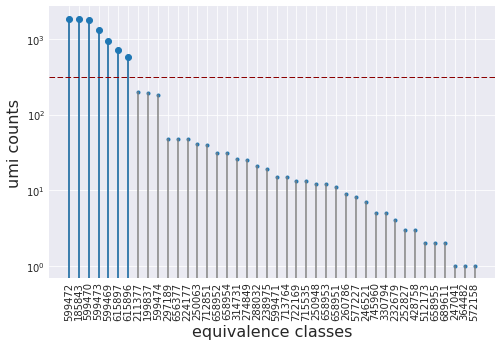

In [142]:
sns.set_style("darkgrid")

threshold=0.01*T.shape[1]

gene_ecs=gene_ecs0[np.where(np.array(ec_counts)>threshold)[0]]
upto=len(gene_ecs)

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical')
# plt.xlim([0,len(b)+0.9])

plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts",fontsize=16)
plt.yscale('log')
plt.show()

In [84]:
print(gene_ecs)

[185843 599469 599470 599472 599473 615896 615897]


In [143]:
associated_genes=[]
for ec in gene_ecs:
    associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
associated_genes=np.unique(associated_genes)
print(associated_genes)

['PTPRC']


In [144]:
ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])

In [145]:
ecidx

array([ 62333, 214260, 214261, 214263, 214264, 223216, 223217])

In [146]:
eq_classes=[]
for i in ecidx:
    tx_indices=EC_dict[nonzero_ec[i]]
    tx_ens=[TX_to_ENST[t] for t in tx_indices]
    eq_classes+=[tx_ens]

In [147]:
import json
eq_dict={}
for i in range(len(eq_classes)):
    eq_dict[str(gene_ecs[i])] = list(np.sort(eq_classes[i]))
print(json.dumps(eq_dict, indent=1))

{
 "185843": [
  "ENST00000348564",
  "ENST00000442510"
 ],
 "599469": [
  "ENST00000348564",
  "ENST00000348564_utr_mod4",
  "ENST00000442510",
  "ENST00000442510_utr_mod4"
 ],
 "599470": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod4",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod4"
 ],
 "599472": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod3",
  "ENST00000348564_utr_mod4",
  "ENST00000367367",
  "ENST00000367367_utr_mod3",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod3",
  "ENST00000442510_utr_mod4",
  "ENST00000529828",
  "ENST00000529828_utr_mod3"
 ],
 "599473": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod3",
  "ENST00000348564_utr_mod4",
  "ENST00000367367",
  "ENST00000367367_utr_mod3",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod3",
  "ENST00000442510_utr_mod4",
  "ENST00000529828

# LogR

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import math

In [149]:
labels=[]
for name in cellnames:
    if name[-1]=='N':
        labels+=[0]
    elif name[-1]=='M':
        labels+=[1]
    else:
        labels+=[2]
labels=np.array(labels)

In [150]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [151]:
X=T.T

In [152]:
X_naive=X[np.squeeze(labels==0),:]
X_mem=X[np.squeeze(labels==1),:]
X_cyto=X[np.squeeze(labels==2),:]




print("naive cells: ",X_naive.shape[0])
print("mem cells: ",X_mem.shape[0])
print("cyto cells: ",X_cyto.shape[0])

naive cells:  9923
mem cells:  9994
cyto cells:  11914


In [153]:
np.random.seed(0)
samples=3000

randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
randperm3=np.random.permutation(X_cyto.shape[0])

In [154]:
sns.set_style("white")

(3000, 342642)
(3000, 342642)
pval= 1.5254861502778105e-05


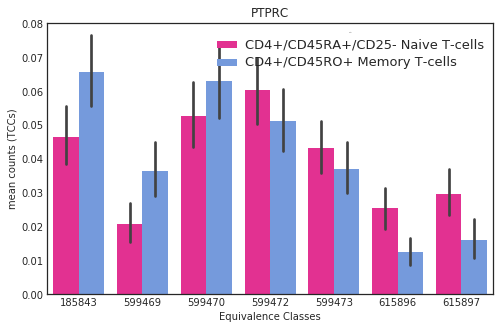

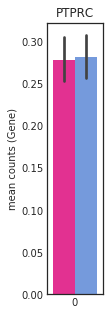

In [155]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:                0.004124
Time:                        10:04:59   Log-Likelihood:                -4141.7
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 1.512e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.028      0.592      0.554      -0.038       0.071
x1            -0.2808      0.

<Container object of 3 artists>

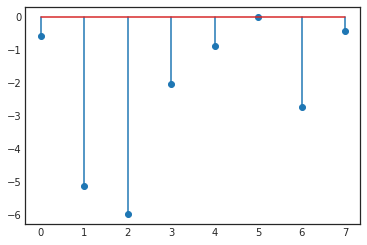

In [156]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342642)
(3000, 342642)
pval= 0.7540008694063847


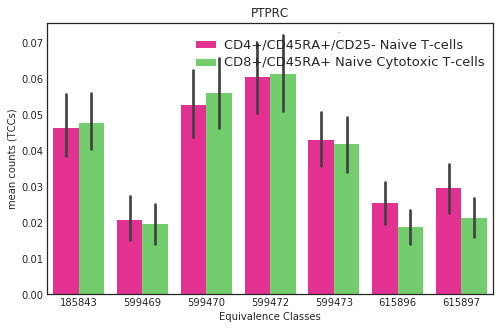

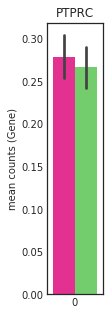

In [157]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.692795
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:               0.0005076
Time:                        10:05:01   Log-Likelihood:                -4156.8
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                    0.7538
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.028     -0.164      0.870      -0.059       0.050
x1            -0.0193      0.

<Container object of 3 artists>

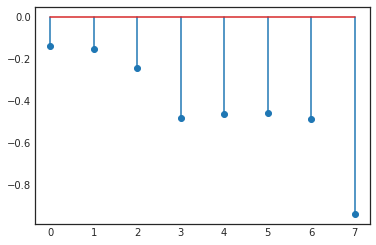

In [158]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342642)
(3000, 342642)
pval= 0.00048420219651168495


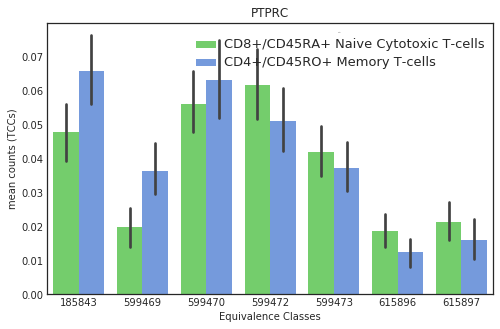

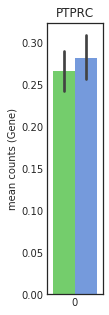

In [159]:
#positive control 

X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]



print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

Optimization terminated successfully.
         Current function value: 0.690971
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Jun 2018   Pseudo R-squ.:                0.003140
Time:                        10:05:04   Log-Likelihood:                -4145.8
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 0.0004794
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.028      0.716      0.474      -0.035       0.075
x1            -0.2585      0.

<Container object of 3 artists>

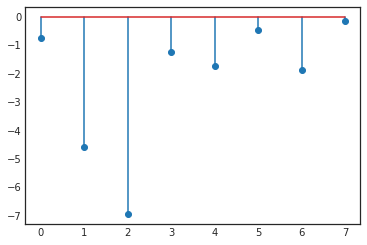

In [160]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

In [55]:
from scipy.stats import ttest_ind

def ttest_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    
    pvals=[]
    for j in range(k):
        a=X1_ecidx[:,j]
        b=X2_ecidx[:,j]
        [o,p]=ttest_ind(a,b,equal_var=False)
        pvals+=[p]
    pval=np.min([1,np.min(np.array(pvals))*k])
    
    
    return pval

### Mem-Naive

In [56]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t ttest pval=',tpval)
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n ttest Avg. p-value: ",np.mean(pvals_t_test))

0 	 logr pval= 9.164955242280115e-06 	 sepLR pval= 0.0003191484297788705 	 ttest pval= 0.00034778523159686493
1 	 logr pval= 9.131709235776775e-06 	 sepLR pval= 5.837464455149544e-07 	 ttest pval= 6.861267877877658e-07
2 	 logr pval= 0.00014809400277682183 	 sepLR pval= 0.003206780079689664 	 ttest pval= 0.0037718168632925363
3 	 logr pval= 0.0004290464992247056 	 sepLR pval= 0.0076379459672890615 	 ttest pval= 0.00853549513523547
4 	 logr pval= 8.154019632722331e-06 	 sepLR pval= 3.570212550008112e-05 	 ttest pval= 5.883217771593073e-05
5 	 logr pval= 0.13061808231607452 	 sepLR pval= 0.3778712042555341 	 ttest pval= 0.38202381730088913
6 	 logr pval= 5.0075341206934354e-08 	 sepLR pval= 1.6655098595830253e-05 	 ttest pval= 1.862028967144264e-05
7 	 logr pval= 0.00018663101900817658 	 sepLR pval= 0.01612637845899645 	 ttest pval= 0.01686636618097294
8 	 logr pval= 0.03081099399778786 	 sepLR pval= 0.021629614503863026 	 ttest pval= 0.02225744677725744
9 	 logr pval= 0.0002119970234115

76 	 logr pval= 0.0001620944957180237 	 sepLR pval= 0.012361533525636514 	 ttest pval= 0.012699897301309718
77 	 logr pval= 0.04279826741942394 	 sepLR pval= 0.01969381191455455 	 ttest pval= 0.02054184375930221
78 	 logr pval= 1.8021271475099354e-07 	 sepLR pval= 4.329063901131747e-06 	 ttest pval= 5.366295533229349e-06
79 	 logr pval= 6.146101079906874e-05 	 sepLR pval= 0.0028043589367281463 	 ttest pval= 0.003199614448732558
80 	 logr pval= 0.003363615411195675 	 sepLR pval= 0.002501295855633856 	 ttest pval= 0.003749989454779457
81 	 logr pval= 7.183364443485996e-05 	 sepLR pval= 0.00014125442617285433 	 ttest pval= 0.00015436202371171825
82 	 logr pval= 1.3152821347506283e-05 	 sepLR pval= 7.590181838412757e-05 	 ttest pval= 8.263622669342686e-05
83 	 logr pval= 2.8101754284359792e-05 	 sepLR pval= 0.0001877169597573891 	 ttest pval= 0.00022097947088584803
84 	 logr pval= 0.08391505274448108 	 sepLR pval= 0.1452620700363909 	 ttest pval= 0.14796169650920313
85 	 logr pval= 1.43457

151 	 logr pval= 1.6370756000139153e-05 	 sepLR pval= 0.004359572329714179 	 ttest pval= 0.004662920450157182
152 	 logr pval= 6.345000364138542e-05 	 sepLR pval= 0.007471965889036758 	 ttest pval= 0.007806141274307705
153 	 logr pval= 0.00014137999372021426 	 sepLR pval= 0.029869461012080212 	 ttest pval= 0.03253281460201937
154 	 logr pval= 0.00034043719656007276 	 sepLR pval= 0.008368314967601154 	 ttest pval= 0.00926650232727452
155 	 logr pval= 8.901893293744578e-05 	 sepLR pval= 0.002176317361612501 	 ttest pval= 0.002355656948680542
156 	 logr pval= 1.428831043481793e-07 	 sepLR pval= 6.275182233317356e-05 	 ttest pval= 6.86306762007e-05
157 	 logr pval= 0.0014205219201965935 	 sepLR pval= 0.004696244994123577 	 ttest pval= 0.005072952530090043
158 	 logr pval= 0.007817823804434743 	 sepLR pval= 0.006321435309396217 	 ttest pval= 0.006570150952749549
159 	 logr pval= 0.016807040364074433 	 sepLR pval= 0.1567152170239593 	 ttest pval= 0.1628002197872283
160 	 logr pval= 0.0836320

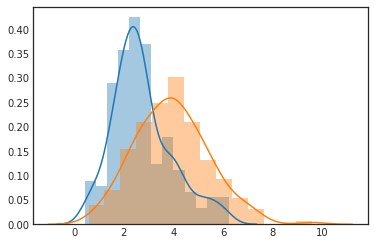

In [57]:
pvals_t_test1=pvals_t_test
pvals_sep_logR1=pvals_sep_logR
pvals1=pvals

sns.distplot(-np.log10(pvals_sep_logR1))
sns.distplot(-np.log10(pvals1))
# sns.distplot(-np.log10(pvals_t_test1),hist=False,color='k')

### Cyto-Mem

In [58]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_cyto.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_cyto[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t ttest pval=',tpval)
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n ttest Avg. p-value: ",np.mean(pvals_t_test))

0 	 logr pval= 2.7329784812013536e-05 	 sepLR pval= 0.0006096265708371851 	 ttest pval= 0.0008424315641669658
1 	 logr pval= 0.0018591570982944283 	 sepLR pval= 0.00841189525664221 	 ttest pval= 0.009059589864991786
2 	 logr pval= 1.2153200820153032e-05 	 sepLR pval= 0.0006626042501037821 	 ttest pval= 0.0007233412243527805
3 	 logr pval= 2.049849770036083e-06 	 sepLR pval= 0.00012007382632051034 	 ttest pval= 0.00017053990128578934
4 	 logr pval= 0.00028397128374590963 	 sepLR pval= 0.01009200581781855 	 ttest pval= 0.011748967925027025
5 	 logr pval= 2.6473091004453053e-05 	 sepLR pval= 0.001666725070846642 	 ttest pval= 0.0022665297922481067
6 	 logr pval= 5.5010241239883406e-05 	 sepLR pval= 0.0005629880585833469 	 ttest pval= 0.000597762781373485
7 	 logr pval= 0.00032402358629046724 	 sepLR pval= 0.0016969588633032329 	 ttest pval= 0.0017645029731523357
8 	 logr pval= 0.009336972824486645 	 sepLR pval= 0.011289996786688294 	 ttest pval= 0.011811938313249759
9 	 logr pval= 0.01777

76 	 logr pval= 0.0006908688185098821 	 sepLR pval= 0.031138209019799468 	 ttest pval= 0.03362389331505512
77 	 logr pval= 0.0005765451918745557 	 sepLR pval= 0.00035736778556239024 	 ttest pval= 0.000527955843111807
78 	 logr pval= 0.00045581107327763437 	 sepLR pval= 0.0042940390424190955 	 ttest pval= 0.005219317101642528
79 	 logr pval= 0.012796160526133193 	 sepLR pval= 0.03724779831231739 	 ttest pval= 0.03792375969650374
80 	 logr pval= 0.015365327787565386 	 sepLR pval= 0.08056509266218559 	 ttest pval= 0.09015885736043708
81 	 logr pval= 2.6807936194805926e-05 	 sepLR pval= 9.270739227729141e-05 	 ttest pval= 0.00010331118076832857
82 	 logr pval= 0.0008724752468091124 	 sepLR pval= 0.027780899960757055 	 ttest pval= 0.02995398125916307
83 	 logr pval= 0.0014081524594201644 	 sepLR pval= 0.008609678676382515 	 ttest pval= 0.009010627829482646
84 	 logr pval= 2.9557219155540437e-06 	 sepLR pval= 0.0001946166880685274 	 ttest pval= 0.00024650316779895005
85 	 logr pval= 1.381247

151 	 logr pval= 0.0001680450106084086 	 sepLR pval= 0.012061400072501671 	 ttest pval= 0.012863012681657453
152 	 logr pval= 0.036489601838385344 	 sepLR pval= 0.05317242089013685 	 ttest pval= 0.05402620955257836
153 	 logr pval= 1.9298181789251245e-05 	 sepLR pval= 0.00166636438319967 	 ttest pval= 0.002180049505657724
154 	 logr pval= 0.0008554961298582464 	 sepLR pval= 0.018926753537371943 	 ttest pval= 0.022102223427609872
155 	 logr pval= 4.3438957098018705e-08 	 sepLR pval= 0.00031493465179477376 	 ttest pval= 0.0006862380569361395
156 	 logr pval= 0.010542569011286362 	 sepLR pval= 0.04330329014525114 	 ttest pval= 0.044399247672799104
157 	 logr pval= 0.0031555118882778954 	 sepLR pval= 0.006313111114174319 	 ttest pval= 0.009255365730821842
158 	 logr pval= 0.0034446493250060994 	 sepLR pval= 0.010303316056601619 	 ttest pval= 0.010520461250458843
159 	 logr pval= 0.0027947981849936188 	 sepLR pval= 0.0030642442865216335 	 ttest pval= 0.0046366157196815125
160 	 logr pval= 0

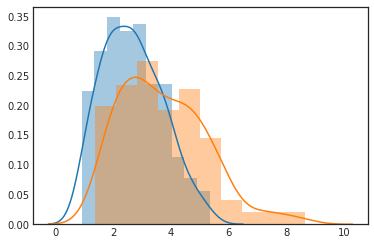

In [59]:
pvals_t_test2=pvals_t_test
pvals_sep_logR2=pvals_sep_logR
pvals2=pvals

sns.distplot(-np.log10(pvals_sep_logR2),bins=10)
sns.distplot(-np.log10(pvals2),bins=10)

### Naive-Cyto

In [60]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_cyto.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_cyto[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t ttest pval=',tpval)
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n ttest Avg. p-value: ",np.mean(pvals_t_test))

0 	 logr pval= 0.5750259554504038 	 sepLR pval= 1.0 	 ttest pval= 1.0
1 	 logr pval= 0.19044778265908846 	 sepLR pval= 0.08599318675790724 	 ttest pval= 0.09158680040577645
2 	 logr pval= 0.003937693366518169 	 sepLR pval= 0.002654425405940075 	 ttest pval= 0.0040896871768939256
3 	 logr pval= 0.7398189382797997 	 sepLR pval= 0.8603785980425247 	 ttest pval= 0.8639660922940926
4 	 logr pval= 0.484117148015188 	 sepLR pval= 1.0 	 ttest pval= 1.0
5 	 logr pval= 0.0008477705133504987 	 sepLR pval= 0.0025929073009145487 	 ttest pval= 0.0027970176760915492
6 	 logr pval= 0.1269289458257261 	 sepLR pval= 0.13762496745469266 	 ttest pval= 0.13960414140572724
7 	 logr pval= 0.389194543337801 	 sepLR pval= 1.0 	 ttest pval= 1.0
8 	 logr pval= 0.8479782094255849 	 sepLR pval= 1.0 	 ttest pval= 1.0
9 	 logr pval= 0.48100634586487645 	 sepLR pval= 0.2854197517241155 	 ttest pval= 0.2927366556626627
10 	 logr pval= 0.006305122159464216 	 sepLR pval= 0.011013361484032314 	 ttest pval= 0.011590590817

83 	 logr pval= 0.08421034444080422 	 sepLR pval= 0.18176504836187757 	 ttest pval= 0.18613057932101726
84 	 logr pval= 0.3229127724975973 	 sepLR pval= 1.0 	 ttest pval= 1.0
85 	 logr pval= 0.0019028772743350242 	 sepLR pval= 0.018010468688075987 	 ttest pval= 0.021006418525535288
86 	 logr pval= 0.0007684772775167215 	 sepLR pval= 0.022470955720270247 	 ttest pval= 0.024383999203690977
87 	 logr pval= 0.6412899761032769 	 sepLR pval= 1.0 	 ttest pval= 1.0
88 	 logr pval= 0.8729649062758376 	 sepLR pval= 1.0 	 ttest pval= 1.0
89 	 logr pval= 0.05214163616723011 	 sepLR pval= 0.28565729084434144 	 ttest pval= 0.29146902916146444
90 	 logr pval= 0.06499279380561129 	 sepLR pval= 0.04616401237108647 	 ttest pval= 0.04837360477923433
91 	 logr pval= 0.24681602409609482 	 sepLR pval= 0.26208741711628003 	 ttest pval= 0.2678298858337307
92 	 logr pval= 0.8428920541733345 	 sepLR pval= 1.0 	 ttest pval= 1.0
93 	 logr pval= 0.20626516123992544 	 sepLR pval= 0.4315843919912302 	 ttest pval= 0.

164 	 logr pval= 0.07904808951837794 	 sepLR pval= 0.04793009463271325 	 ttest pval= 0.04971740403070987
165 	 logr pval= 0.43133461126589523 	 sepLR pval= 0.15928612290591804 	 ttest pval= 0.16216694649587182
166 	 logr pval= 0.2936007437546235 	 sepLR pval= 0.4371090755012358 	 ttest pval= 0.4421755610428286
167 	 logr pval= 0.08604841837942279 	 sepLR pval= 0.145263379377077 	 ttest pval= 0.147551565691965
168 	 logr pval= 0.12586645983080447 	 sepLR pval= 0.007797337991703457 	 ttest pval= 0.008294428365557978
169 	 logr pval= 0.3234710138767075 	 sepLR pval= 0.07738493240140532 	 ttest pval= 0.08303599531640782
170 	 logr pval= 0.26377251568147253 	 sepLR pval= 0.10120904122859031 	 ttest pval= 0.10459891938932092
171 	 logr pval= 0.412722357436471 	 sepLR pval= 0.1298408773452423 	 ttest pval= 0.1334712976937605
172 	 logr pval= 0.04860639823910784 	 sepLR pval= 0.04037030962385746 	 ttest pval= 0.04531290127598603
173 	 logr pval= 0.14440190861296964 	 sepLR pval= 0.212664458131

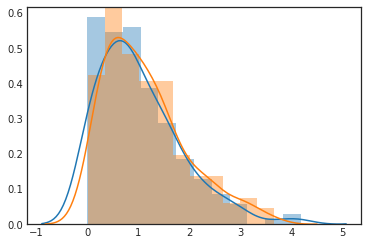

In [61]:
pvals_t_test3=pvals_t_test
pvals_sep_logR3=pvals_sep_logR
pvals3=pvals

sns.distplot(-np.log10(pvals_sep_logR3))
sns.distplot(-np.log10(pvals3))